In [714]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

# Jos Stam Paper - http://graphics.cs.cmu.edu/nsp/course/15-464/Fall09/papers/StamFluidforGames.pdf
# Gonkee Video - https://www.youtube.com/watch?v=qsYE1wMEMPA
# Numba - https://www.youtube.com/watch?v=qsYE1wMEMPA
# Coding Train - https://www.youtube.com/watch?v=alhpH6ECFvQ&t=1165s

In [715]:
N_time_steps = 50

N = 50
# 0, N+1 are reserved for boundary cells
sz = N + 2
dt = 0.1
diff = 5
visc = 5

animation_frames = []

# densities
dens = np.zeros((sz, sz))
dens0 = np.zeros((sz, sz))

# velocities (u is x, v is y), at center of each grid cell
u0 = np.zeros((sz, sz))
u = np.zeros((sz, sz))

v0 = np.zeros((sz, sz))
v = np.zeros((sz, sz))

In [716]:
# full - reflect
# lr - copy top and bottom, reflect others
# ud - copy left and right, reflect others

def set_bnd(b, X):
    for i in range(1, N+1):
        X[0][i] = -X[1][i] if b == "lr" else X[1][i]
        X[N+1][i] = -X[N][i] if b == "lr" else X[N][i]
        
        X[i][0] = -X[i][1] if b == "ud" else X[i][1]
        X[i][N+1] = -X[i][N] if b == "ud" else X[i][N]
    
    #do corners - average of 2 around
    X[0][0] = (X[1][0] + X[0][1]) * 0.5
    X[0][N+1] = (X[1][N+1] + X[0][N]) * 0.5
    X[N+1][0] = (X[N][0] + X[N+1][1]) * 0.5
    X[N+1][N+1] = (X[N][N+1] + X[N+1][N]) * 0.5
    
def addSource(i, j, X, x):
    X[i][j] += dt * x

In [717]:
# Diffuse backwards in time: x0[IX(i,j)] = x[IX(i,j)] - a*(x[IX(i-1,j)]+x[IX(i+1,j)]+x[IX(i,j-1)]+x[IX(i,j+1)] -4*x[IX(i,j)]);
# ==> ( x0[IX(i,j)] + a*(x[IX(i-1,j)]+x[IX(i+1,j)]+x[IX(i,j-1)]+x[IX(i,j+1)]) ) / ( 1 + 4*a )

def diffuse(X, X0, coef, b = "full", n_iter = 20):
        # Gauss-Seidel: observation - very few non-zero values in matrix & strictly diagonally dominant
        # start with incorrect values, solve by iteratively calculating assuming incorrect values are correct, then setting result as the new incorrect value
        a = dt * sz * sz * coef
        
        for k in range(n_iter):
            for i in range(1, N+1):
                for j in range(1, N+1):
                    X[i][j] = (X0[i][j] + a*(X[i-1][j] + X[i][j-1] + X[i][j+1] + X[i+1][j]))/(1+4*a)
                    
            # what to do when collision with boundary
            set_bnd(b, X)

In [718]:
# linear interpolation, loc x in length 1, a to b
def lerp(a, b, x):
    slope = b - a
    return a + slope * x
    
# advect backwards (start from center and go back), using next velocity to linear interpolate, to find density contributions
# Note: may need coefficient for multiplier ==> mult changes with dt?
def advect(X, X0, b = "full", mult = 1):
    for i in range(1, N+1):
        for j in range(1, N+1):
            
            y = dt * v[i][j] + i
            x = dt * u[i][j] + j
            
            if (x < 0.5):
                x = 0.5
                
            if (x > N + 0.5):
                x= N + 0.5;
                
            if (y < 0.5):
                y = 0.5
                
            if (y > N + 0.5):
                y= N + 0.5;
            
            frac_y = y - math.floor(y)
            frac_x = x - math.floor(x)
            
            y = math.floor(y)
            x = math.floor(x)
                
            #density (or arr X) at four corners
            [ul, dl, ur, dr] = [X0[x][y], X0[x][y+1], X0[x+1][y], X0[x+1][y+1]]
            
            #first interpolate looking through the y dimension
            y0 = lerp(ul, dl, frac_y)
            y1 = lerp(ur, dr, frac_y)
            
            #then interpolate looking through x dimension
            res = lerp(y0, y1, frac_x)

            X[i][j] += mult * res

    set_bnd(b, X)

In [719]:
'''
To calculate the curl-free field of a given vector field using Poisson equations, you can use the following steps:

Define your vector field as a function of the coordinates of the grid points. Let's call this vector field V(x,y,z), where x,y,z are the coordinates of a given grid point.

Calculate the curl of the vector field using the curl operator: curl(V) = (dVz/dy - dVy/dz, dVx/dz - dVz/dx, dVy/dx - dVx/dy). This will give you a new vector field that represents the direction and magnitude of the curl of the original vector field at each grid point.

Use the Poisson equation to find a scalar potential function φ(x,y,z) that satisfies the equation ∇²φ = -div(curl(V)), where ∇² is the Laplace operator and div is the divergence operator. This scalar potential function will represent the curl-free component of the original vector field.

Calculate the gradient of the scalar potential function using the gradient operator: grad(φ) = (∂φ/∂x, ∂φ/∂y, ∂φ/∂z). This will give you a new vector field that represents the direction and magnitude of the curl-free component of the original vector field at each grid point.

Subtract the curl-free vector field from the original vector field to get the remaining curl component: V_curl = V - grad(φ).

Following these steps should allow you to calculate the curl-free component of your vector field using Poisson equations. Note that the calculation of the scalar potential function φ can be done using various numerical methods such as finite difference, finite element, or spectral methods, depending on the specifics of your problem.
'''

# By helmholtz's theorem, every velocity field is the addition of a curl-free and divergence-free vector field. In this function, we compute the divergence-free field by computing curl-free and subtracting it from original

def project(u, v, p, div, n_iter=20):
    h = 1.0 / N
    
    for i in range(1, N+1):
        for j in range(1, N+1):
            div[i][j] = -0.5 * h * (u[i+1][j] - u[i-1][j] + v[i][j+1] - v[i][j-1])
            p[i][j] = 0
    
    set_bnd("full", div)
    set_bnd("full", p)
    
    for k in range(n_iter):
        for i in range(1, N+1):
            for j in range(1, N+1):
                p[i][j] = (div[i][j] + p[i-1][j] + p[i+1][j] + p[i][j-1] + p[i][j+1]) / 4
        set_bnd("full", p)
    
    for i in range(1, N+1):
        for j in range(1, N+1):
            u[i][j] -= 0.5 * (p[i+1][j] - p[i-1][j]) / h
            v[i][j] -= 0.5 * (p[i][j+1] - p[i][j-1]) / h
            
    set_bnd("lr", u)
    set_bnd("ud", v)

In [720]:
import random

theta = random.random() * math.pi * 2
def rotate(speed = 2 * math.pi / 15, prob = 0.15):
    global theta
    # expected to change direction in 1/prob seconds
    prob *= dt

    if random.random() < prob:
        speed *= -1
        print("Switched")
        
    theta += speed * dt
    
    
def vel_step(i_u = N//2, i_v = N//2, j_u = N//2, j_v = N//2, radius = 20):
    rotate()
    radius *= sz
    addSource (i_u, j_u, u0, math.cos(theta) * radius)
    addSource (i_v, j_v, v0, math.sin(theta) * radius)

#     print(math.cos(theta) * radius)
#     print(math.cos(theta))
#     print(math.sin(theta))
#     print(radius)
#     print(sz * sz * 5)
    
#     print(dt * 500 * N)
#     print(u0[i_u][j_u])
#     print(np.max(u0))
    
    diffuse (u0, u, visc, b="lr")
    diffuse (v0, v, visc, b="ud")
    
    # project first because advect works better with a divergence-free v-field
    #BELOW MAY BE WRONG -- Swapped 0 and cur?
    project(u0, v0, u, v)
        
    advect (u, u0, b="lr")
    advect (v, v0, b="ud")
    
    project(u, v, u0, v0)
    
    
def dens_step(x = N//2, y = N//2, x_val = 1):
    # below might be wrong?
    addSource(x, y, dens0, sz * x_val)
    diffuse (dens, dens0, diff)
    advect (dens, dens0)

    
def fade():
    for i in range(sz):
        for j in range(sz):
            if dens[i][j] > 0:
                dens[i][j] *= 0.95
#                 dens[i][j] -= 0.01

  0%|          | 0/50 [00:00<?, ?it/s]

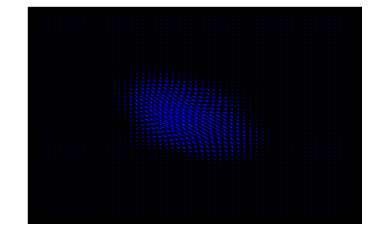

  2%|▏         | 1/50 [00:00<00:25,  1.95it/s]

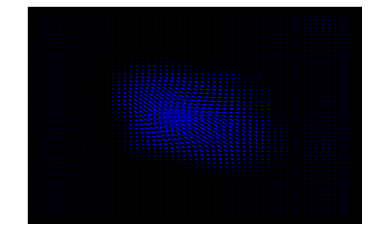

  4%|▍         | 2/50 [00:00<00:24,  1.99it/s]

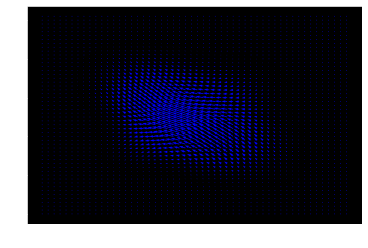

  6%|▌         | 3/50 [00:01<00:23,  2.01it/s]

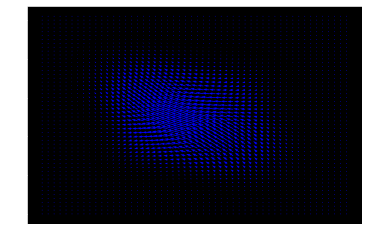

  8%|▊         | 4/50 [00:01<00:22,  2.03it/s]

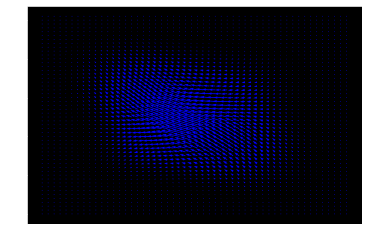

 10%|█         | 5/50 [00:02<00:22,  2.04it/s]

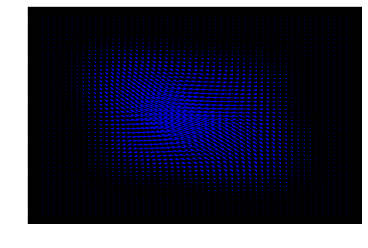

 12%|█▏        | 6/50 [00:02<00:22,  1.97it/s]

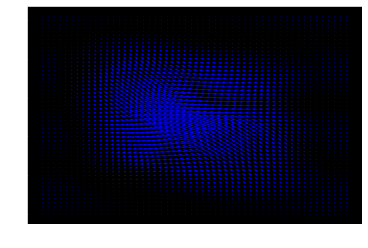

 14%|█▍        | 7/50 [00:03<00:21,  2.00it/s]

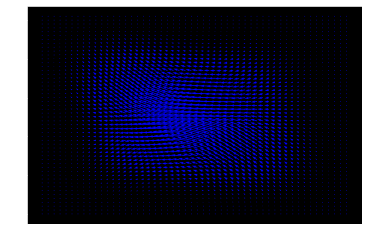

 16%|█▌        | 8/50 [00:03<00:20,  2.02it/s]

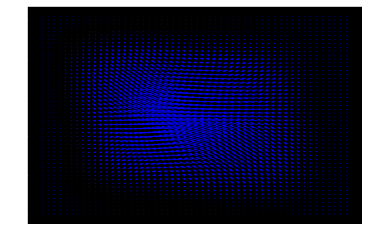

 18%|█▊        | 9/50 [00:04<00:20,  2.04it/s]

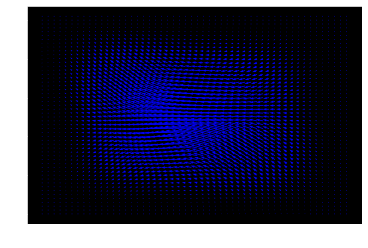

 20%|██        | 10/50 [00:04<00:19,  2.05it/s]

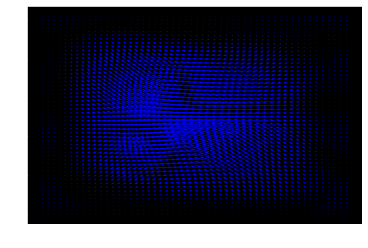

 22%|██▏       | 11/50 [00:05<00:19,  2.02it/s]

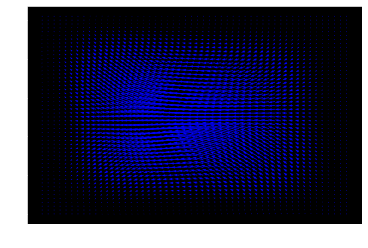

 24%|██▍       | 12/50 [00:05<00:18,  2.04it/s]

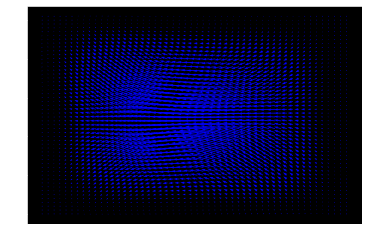

 26%|██▌       | 13/50 [00:06<00:18,  2.05it/s]

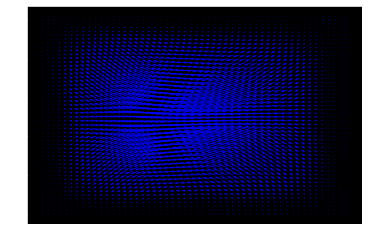

 28%|██▊       | 14/50 [00:06<00:17,  2.05it/s]

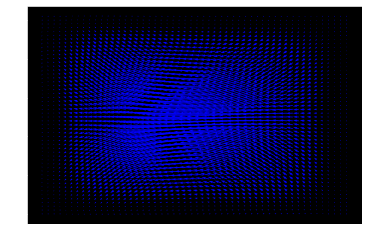

 30%|███       | 15/50 [00:07<00:17,  2.05it/s]

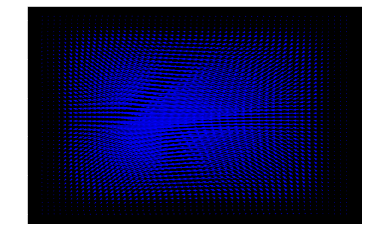

 32%|███▏      | 16/50 [00:07<00:16,  2.06it/s]

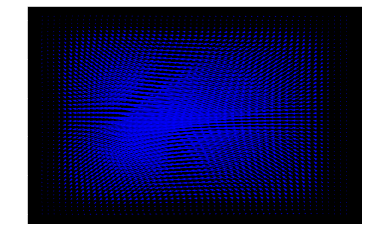

 34%|███▍      | 17/50 [00:08<00:16,  2.01it/s]

Switched


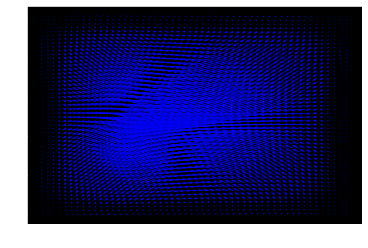

 36%|███▌      | 18/50 [00:08<00:15,  2.02it/s]

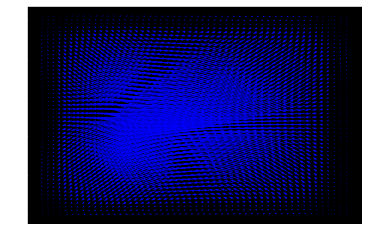

 38%|███▊      | 19/50 [00:09<00:15,  2.02it/s]

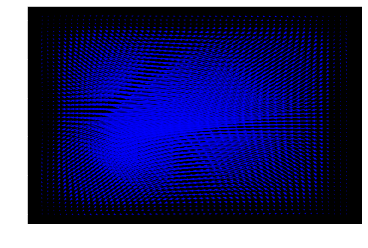

 40%|████      | 20/50 [00:09<00:14,  2.04it/s]

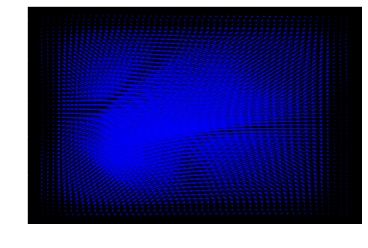

 42%|████▏     | 21/50 [00:10<00:14,  2.04it/s]

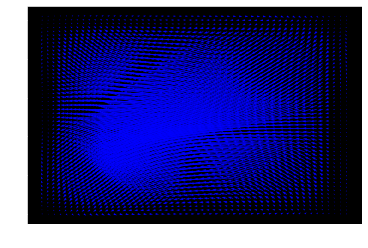

 44%|████▍     | 22/50 [00:10<00:13,  2.04it/s]

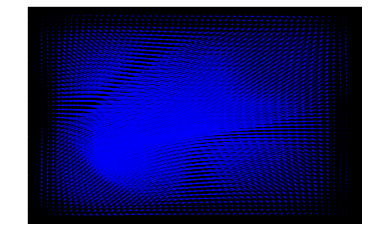

 46%|████▌     | 23/50 [00:11<00:13,  1.99it/s]

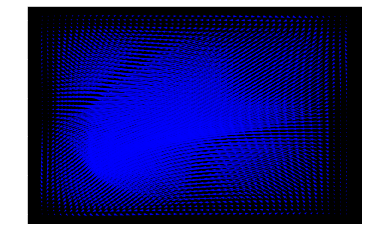

 48%|████▊     | 24/50 [00:11<00:12,  2.01it/s]

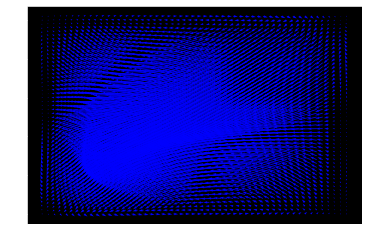

 50%|█████     | 25/50 [00:12<00:12,  2.02it/s]

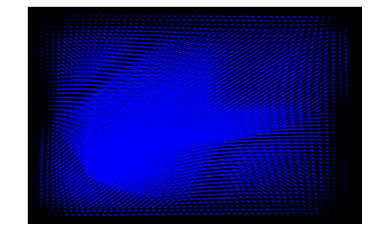

 52%|█████▏    | 26/50 [00:12<00:11,  2.02it/s]

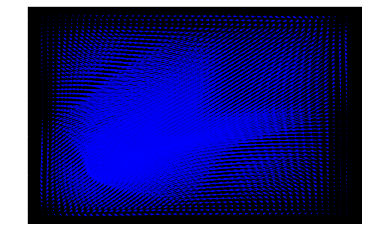

 54%|█████▍    | 27/50 [00:13<00:11,  2.03it/s]

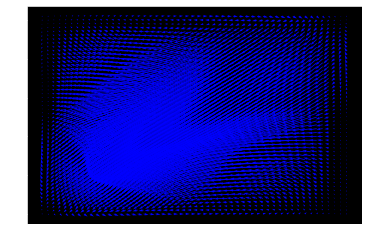

 56%|█████▌    | 28/50 [00:13<00:10,  2.02it/s]

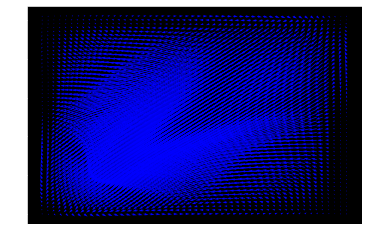

 58%|█████▊    | 29/50 [00:14<00:10,  1.98it/s]

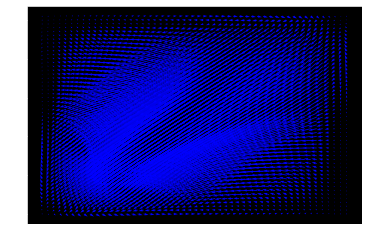

 60%|██████    | 30/50 [00:14<00:10,  2.00it/s]

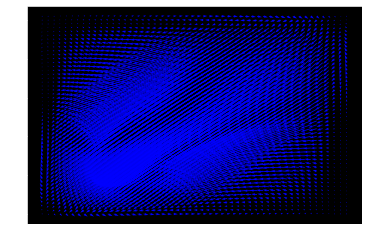

 62%|██████▏   | 31/50 [00:15<00:09,  2.01it/s]

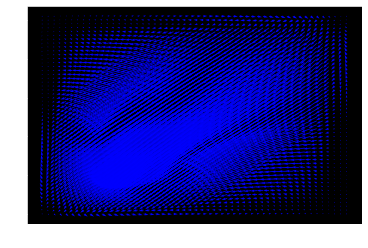

 64%|██████▍   | 32/50 [00:15<00:08,  2.02it/s]

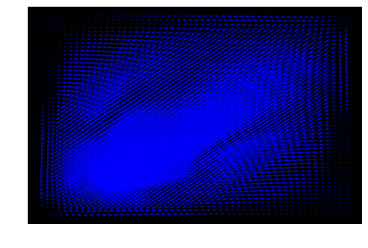

 66%|██████▌   | 33/50 [00:16<00:08,  2.03it/s]

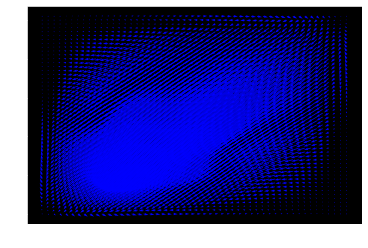

 68%|██████▊   | 34/50 [00:16<00:07,  2.03it/s]

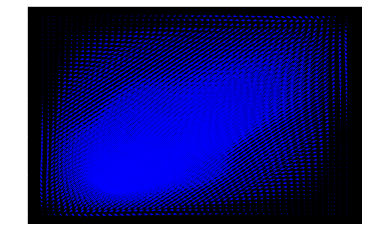

 70%|███████   | 35/50 [00:17<00:07,  1.96it/s]

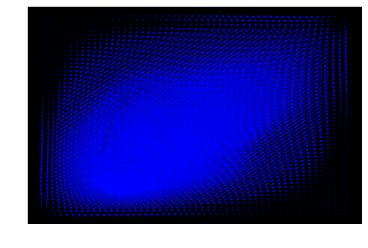

 72%|███████▏  | 36/50 [00:17<00:07,  1.97it/s]

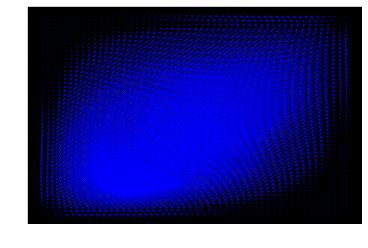

 74%|███████▍  | 37/50 [00:18<00:06,  1.99it/s]

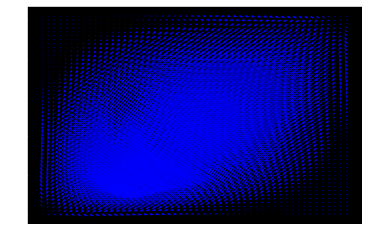

 76%|███████▌  | 38/50 [00:18<00:05,  2.00it/s]

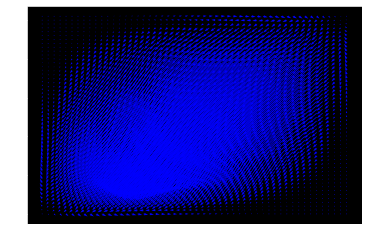

 78%|███████▊  | 39/50 [00:19<00:05,  2.01it/s]

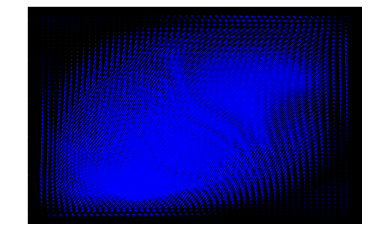

 80%|████████  | 40/50 [00:19<00:04,  2.02it/s]

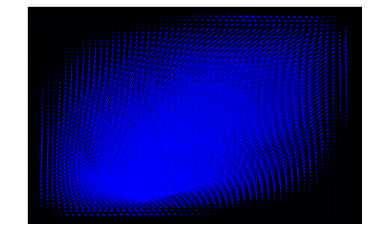

 82%|████████▏ | 41/50 [00:20<00:04,  1.97it/s]

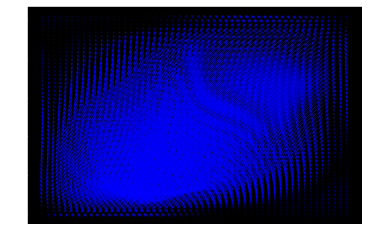

 84%|████████▍ | 42/50 [00:20<00:04,  2.00it/s]

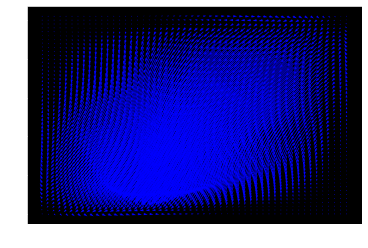

 86%|████████▌ | 43/50 [00:21<00:03,  2.01it/s]

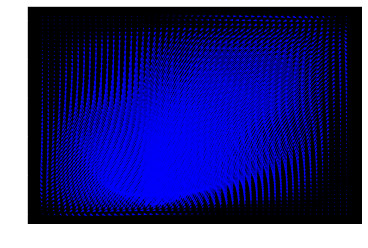

 88%|████████▊ | 44/50 [00:21<00:02,  2.02it/s]

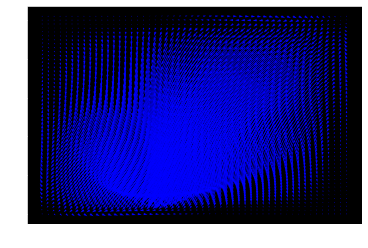

 90%|█████████ | 45/50 [00:22<00:02,  2.03it/s]

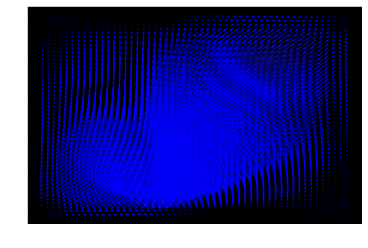

 92%|█████████▏| 46/50 [00:22<00:01,  2.03it/s]

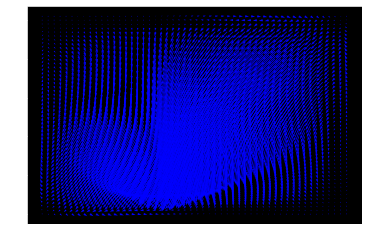

 94%|█████████▍| 47/50 [00:23<00:01,  1.98it/s]

Switched


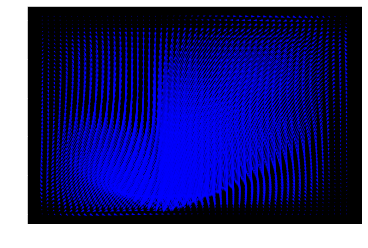

 96%|█████████▌| 48/50 [00:23<00:01,  2.00it/s]

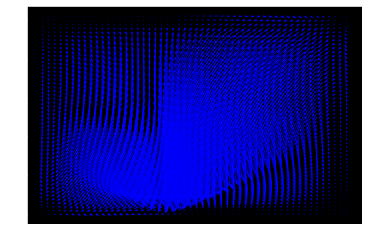

 98%|█████████▊| 49/50 [00:24<00:00,  2.01it/s]

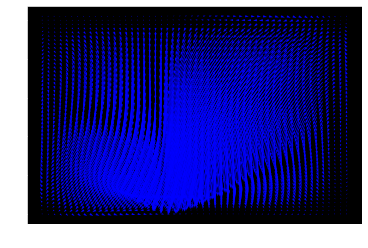

100%|██████████| 50/50 [00:24<00:00,  2.02it/s]

CPU times: user 39.3 s, sys: 13.8 s, total: 53.1 s
Wall time: 24.8 s


In [721]:
%%time

from tqdm import tqdm

for i in tqdm(range(N_time_steps)):
    dens = np.zeros((sz, sz))
    u = np.zeros((sz, sz))
    v = np.zeros((sz, sz))

    vel_step()
    plt.quiver(u, v, color='b', units='xy', scale = max(np.max(u), np.max(v)))
    plt.show()
    dens_step()

    animation_frames.append(dens)
#     print(u)
#     print(np.max(u))
#     print(v)

    dens0 = dens
    v0 = v
    u0 = u

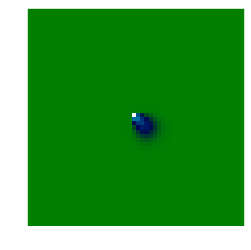

In [722]:
%matplotlib inline
import time
from IPython.display import clear_output

for i in range(N_time_steps):
    # Not by
    clear_output(wait=True)
#     plt.clf()
    
    fig, ax = plt.subplots()
    ax.imshow(animation_frames[i], cmap="ocean")
    plt.show()
    time.sleep(dt)

# plt.imshow(animation_frames[99])
plt.show()
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

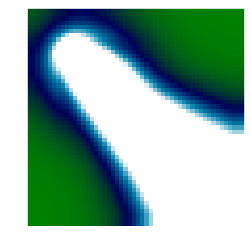

In [650]:
# execute this cell
%matplotlib inline
# %matplotlib notebook

fig, ax = plt.subplots()
im = plt.imshow(animation_frames[0], animated=True, cmap='ocean')

def updatefig(*args):
    im.set_array(animation_frames[args[0]])
    return im,

# ani = animation.FuncAnimation(fig, update, interval=50,
#                               save_count=50)
# plt.show()

ani = FuncAnimation(fig, updatefig, range(N_time_steps), interval = dt * 1000 , blit=True, repeat=True,
                    repeat_delay=1000)

ani.save('asdf.mp4', extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])

plt.show()

# for i in range(N_time_steps):
#     plt.clf()
#     fig, ax = plt.subplots()
#     ax.imshow(animation_frames[99], cmap="ocean")
#     plt.plot()
#     plot.show()
    

  0%|          | 0/1000 [00:00<?, ?it/s]

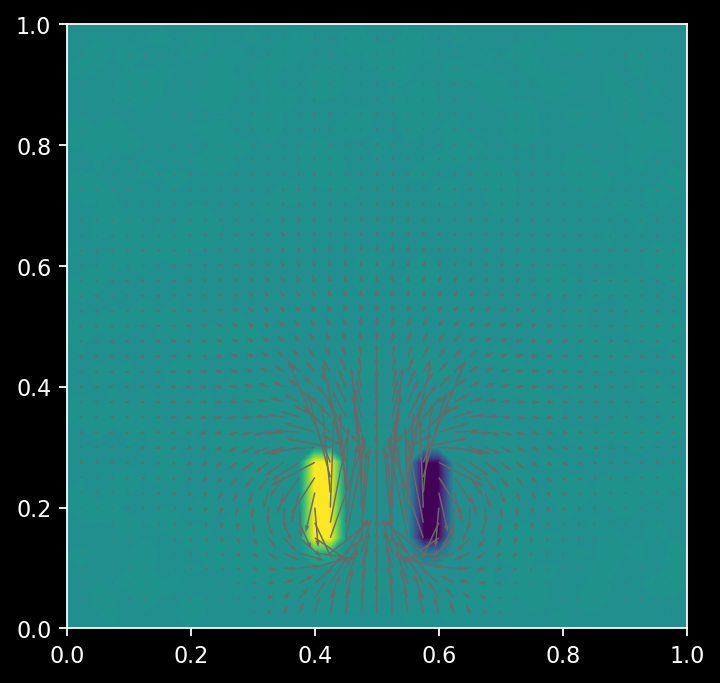

  0%|          | 1/1000 [00:00<03:54,  4.25it/s]

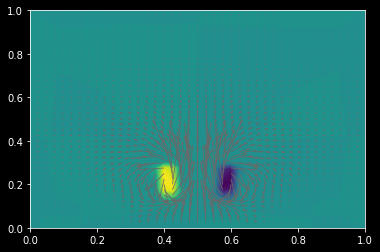

  0%|          | 2/1000 [00:00<03:40,  4.52it/s]

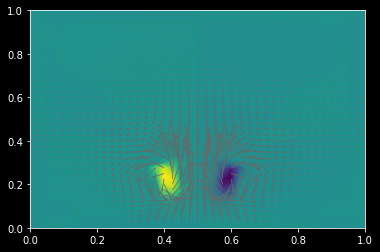

  0%|          | 3/1000 [00:00<03:29,  4.75it/s]

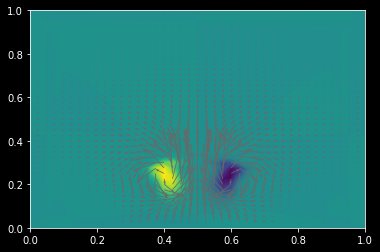

  0%|          | 4/1000 [00:00<03:36,  4.60it/s]

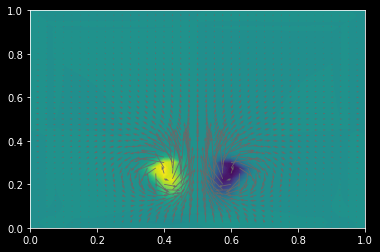

  0%|          | 5/1000 [00:01<03:27,  4.80it/s]

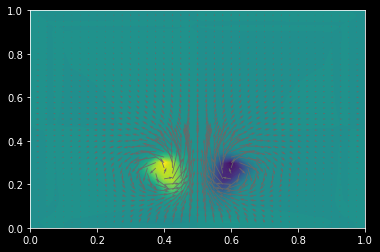

  1%|          | 6/1000 [00:01<03:19,  4.97it/s]

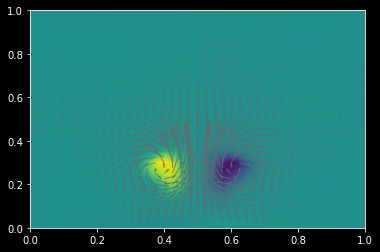

  1%|          | 7/1000 [00:01<03:38,  4.55it/s]


KeyboardInterrupt: 

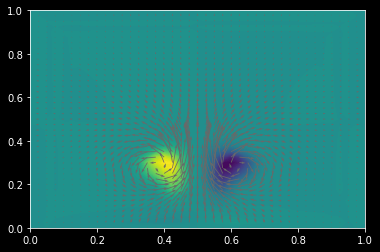

In [332]:
"""
Solves the incompressible Navier Stokes equations using "Stable Fluids" by Jos Stam
in a closed box with a forcing that creates a bloom. 


Momentum:           ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Incompressibility:  ∇ ⋅ u = 0


u:  Velocity (2d vector)
p:  Pressure
f:  Forcing
ν:  Kinematic Viscosity
ρ:  Density
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator


----

A closed box


                                    u = 0
                                    v = 0 

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
u = 0       |      *                             *            |   u = 0
v = 0       |                             *                   |   v = 0
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *            *             *               |
            |           *                             *       |
        0.2 |                       *           *             |
            |                               *                 |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

                                    u = 0
                                    v = 0

* Homogeneous Dirichlet Boundary Condictio

----- 

Forcing Function

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
            |      *                             *            |
            |                             *                   | 
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *           ^ ^ ^ ^ ^ ^                    |
            |           *      | | | | | |                 *  |
        0.2 |                  | | | | | |     *           *  |
            |                  | | | | | |             *      |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

-> Upwards pointing force in the lower center of the domain.


-----

Solution Strategy:

-> Start with zero velocity everywhere: u = [0, 0]

1. Add forces

    w₁ = u + Δt f

2. Convect by self-advection (set the value at the current
   location to be the value at the position backtraced
   on the streamline.) -> unconditionally stable

    w₂ = w₁(p(x, −Δt))

3. Diffuse implicitly (Solve a linear system matrix-free
   by Conjugate Gradient) -> unconditionally stable

    (I − ν Δt ∇²)w₃ = w₂

4.1 Compute a pressure correction (Solve a linear system
    matrix-free by Conjugate gradient)

    ∇² p = ∇ ⋅ w₃

4.2 Correct velocities to be incompressible

    w₄ = w₃ − ∇p

5. Advance to next time step

    u = w₄ 


-> The Boundary Conditions are prescribed indirectly using
   the discrete differential operators.

-----

The solver is unconditionally stable, hence all parameters can be
chosen arbitrarily. Still, be careful that too high timesteps can
make the advection step highly incorrect.
"""
import numpy as np
import scipy.sparse.linalg as splinalg
from scipy import interpolate
import matplotlib.pyplot as plt

# Optional
# import cmasher as cmr
from tqdm import tqdm

DOMAIN_SIZE = 1.0
N_POINTS = 41
N_TIME_STEPS = 1000
TIME_STEP_LENGTH = 0.1

KINEMATIC_VISCOSITY = 0.0001

MAX_ITER_CG = None

def forcing_function(time, point):
    time_decay = np.maximum(
        2.0 - 0.5 * time,
        0.0,
    )

    forced_value = (
        time_decay
        *
        np.where(
            (
                (point[0] > 0.4)
                &
                (point[0] < 0.6)
                &
                (point[1] > 0.1)
                &
                (point[1] < 0.3)
            ),
            np.array([0.0, 1.0]),
            np.array([0.0, 0.0]),
        )
    )

    return forced_value


def main():
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    scalar_shape = (N_POINTS, N_POINTS)
    scalar_dof = N_POINTS**2
    vector_shape = (N_POINTS, N_POINTS, 2)
    vector_dof = N_POINTS**2 * 2

    x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

    # Using "ij" indexing makes the differential operators more logical. Take
    # care when plotting.
    X, Y = np.meshgrid(x, y, indexing="ij")

    coordinates = np.concatenate(
        (
            X[..., np.newaxis],
            Y[..., np.newaxis],
        ),
        axis=-1,
    )

    forcing_function_vectorized = np.vectorize(
        pyfunc=forcing_function,
        signature="(),(d)->(d)",
    )

    def partial_derivative_x(field):
        diff = np.zeros_like(field)

        diff[1:-1, 1:-1] = (
            (
                field[2:  , 1:-1]
                -
                field[0:-2, 1:-1]
            ) / (
                2 * element_length
            )
        )

        return diff

    def partial_derivative_y(field):
        diff = np.zeros_like(field)

        diff[1:-1, 1:-1] = (
            (
                field[1:-1, 2:  ]
                -
                field[1:-1, 0:-2]
            ) / (
                2 * element_length
            )
        )

        return diff

    def laplace(field):
        diff = np.zeros_like(field)

        diff[1:-1, 1:-1] = (
            (
                field[0:-2, 1:-1]
                +
                field[1:-1, 0:-2]
                - 4 *
                field[1:-1, 1:-1]
                +
                field[2:  , 1:-1]
                +
                field[1:-1, 2:  ]
            ) / (
                element_length**2
            )
        )

        return diff
    
    def divergence(vector_field):
        divergence_applied = (
            partial_derivative_x(vector_field[..., 0])
            +
            partial_derivative_y(vector_field[..., 1])
        )

        return divergence_applied
    
    def gradient(field):
        gradient_applied = np.concatenate(
            (
                partial_derivative_x(field)[..., np.newaxis],
                partial_derivative_y(field)[..., np.newaxis],
            ),
            axis=-1,
        )

        return gradient_applied
    
    def curl_2d(vector_field):
        curl_applied = (
            partial_derivative_x(vector_field[..., 1])
            -
            partial_derivative_y(vector_field[..., 0])
        )

        return curl_applied

    def advect(field, vector_field):
        backtraced_positions = np.clip(
            (
                coordinates
                -
                TIME_STEP_LENGTH
                *
                vector_field
            ),
            0.0,
            DOMAIN_SIZE,
        )

        advected_field = interpolate.interpn(
            points=(x, y),
            values=field,
            xi=backtraced_positions,
        )

        return advected_field
    
    def diffusion_operator(vector_field_flattened):
        vector_field = vector_field_flattened.reshape(vector_shape)

        diffusion_applied = (
            vector_field
            -
            KINEMATIC_VISCOSITY
            *
            TIME_STEP_LENGTH
            *
            laplace(vector_field)
        )

        return diffusion_applied.flatten()
    
    def poisson_operator(field_flattened):
        field = field_flattened.reshape(scalar_shape)

        poisson_applied = laplace(field)

        return poisson_applied.flatten()

    plt.style.use("dark_background")
    plt.figure(figsize=(5, 5), dpi=160)

    velocities_prev = np.zeros(vector_shape)
    
    time_current = 0.0
    
    for i in tqdm(range(N_TIME_STEPS)):
        time_current += TIME_STEP_LENGTH

        forces = forcing_function_vectorized(
            time_current,
            coordinates,
        )

        # (1) Apply Forces
        velocities_forces_applied = (
            velocities_prev
            +
            TIME_STEP_LENGTH
            *
            forces
        )

        # (2) Nonlinear convection (=self-advection)
        velocities_advected = advect(
            field=velocities_forces_applied,
            vector_field=velocities_forces_applied,
        )

        # (3) Diffuse
        velocities_diffused = splinalg.cg(
            A=splinalg.LinearOperator(
                shape=(vector_dof, vector_dof),
                matvec=diffusion_operator,
            ),
            b=velocities_advected.flatten(),
            maxiter=MAX_ITER_CG,
        )[0].reshape(vector_shape)

        # (4.1) Compute a pressure correction
        pressure = splinalg.cg(
            A=splinalg.LinearOperator(
                shape=(scalar_dof, scalar_dof),
                matvec=poisson_operator,
            ),
            b=divergence(velocities_diffused).flatten(),
            maxiter=MAX_ITER_CG,
        )[0].reshape(scalar_shape)

        # (4.2) Correct the velocities to be incompressible
        velocities_projected = (
            velocities_diffused
            -
            gradient(pressure)
        )

        # Advance to next time step
        velocities_prev = velocities_projected

        # Plot
        curl = curl_2d(velocities_projected)
        plt.contourf(
            X,
            Y,
            curl,
            levels=100,
        )
        plt.quiver(
            X, 
            Y,
            velocities_projected[..., 0],
            velocities_projected[..., 1],
            color="dimgray",
        )
        plt.draw()
        plt.pause(0.0001)
        plt.clf()

    plt.show()
        


if __name__ == "__main__":
    main()


In [ ]:
\